In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import  preprocessing
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

from qiskit import Aer, QuantumCircuit
from qiskit.algorithms.optimizers import SPSA, COBYLA, GradientDescent
from qiskit.circuit.library import TwoLocal, ZZFeatureMap, ZFeatureMap, PauliFeatureMap
from qiskit.circuit import Parameter
from qiskit.opflow import StateFn, Gradient, I, Z
from qiskit.utils import QuantumInstance

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import CircuitQNN, OpflowQNN
from qiskit_machine_learning.utils.loss_functions import L2Loss, CrossEntropyLoss

In [3]:
df = pd.read_csv('Datasets/Mentor/mock_train_set.csv')
df.head(8)

,0,1,2,3,x
0,2789.26,1000,10,20,0
1,4040.01,1000000,1,1,1
2,2931.20,10000,10000,40,1
3,3896.54,10000,100000,30,1
4,982.06,100,1000,75,0
5,1579.81,1,1000,90,0
6,3031.77,1000000,1000000,35,1
7,860.44,10,100000,60,0


In [4]:
df_test = pd.read_csv('Datasets/Mentor/mock_test_set.csv')
df_test.head(8)

,0,1,2,3,x
0,2988.55,10000,10000,75,1
1,3413.80,1,100,90,0
2,3891.52,1,1,5,0
3,4514.99,10000,1000000,25,1
4,752.29,10,10,90,0
5,1404.13,10000,1000,5,1
6,3390.65,1000000,10000,5,1
7,2620.98,1,10,75,0


In [5]:
f_name_list = list(df)
list(f_name_list)

['0', '1', '2', '3', 'x']

In [6]:
print('Number of empty data in the set: '), df.isnull().sum().sum()
clean_data = df.dropna()

Number of empty data in the set: 


In [7]:
x_org = clean_data.drop('x', axis=1)
cat = clean_data.x

rel = ExtraTreesClassifier()
rel.fit(x_org, cat)

ExtraTreesClassifier()

In [8]:
print(rel.feature_importances_)

[0.13621547 0.47989126 0.28524898 0.0986443 ]


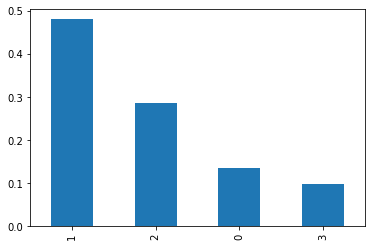

In [9]:
rank_f = pd.Series(rel.feature_importances_, index=x_org.columns)
rank_f.nlargest(20).plot(kind='bar')
plt.show()

In [10]:
corr = clean_data.iloc[:,:-1].corr()
classified = mutual_info_classif(x_org, cat)
class_data = pd.Series(classified, index=x_org.columns)
ordered_f = class_data.sort_values(ascending=False)

In [11]:
ordered_f.head(10)

2    0.334810
1    0.331926
0    0.060894
3    0.000000
dtype: float64

In [12]:
test_ratio = 0.2
seed = 1984
selected_f = clean_data[['0','1','2','3','x']]
selected_test = df_test[['0','1','2','3','x']]

x_train = np.array(selected_f.drop('x', axis =1))
y_train = np.array(selected_f.x)
x = preprocessing.normalize(x_train, axis=0)

x_test = np.array(selected_test.drop('x', axis =1))
y_test = np.array(selected_test.x)
x = preprocessing.normalize(x_test, axis=0)

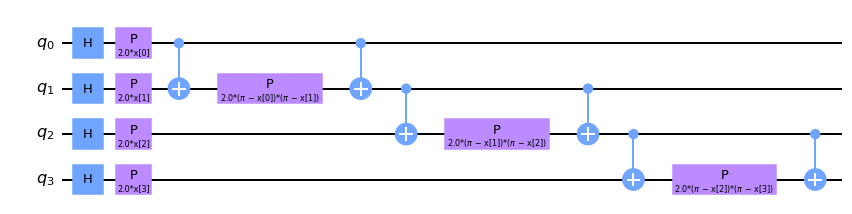

In [13]:
feature_dim = x.shape[1]
emb_layer = 1
ent = 'linear'

fmap = PauliFeatureMap(feature_dimension=feature_dim, reps=emb_layer, entanglement=ent)
fmap.decompose().draw('mpl', scale=1)

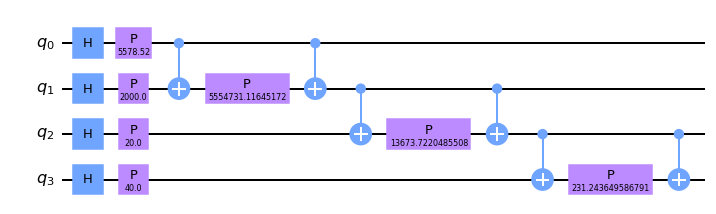

In [14]:
fmap.assign_parameters({k:v for (k,v) in zip(fmap.parameters, x_train[0])}).decompose().draw('mpl', scale=1)

In [15]:
def ansatz_circ(feature_dim, layer, weights):
    ansatz = QuantumCircuit(feature_dim)
    for layer in range(layer):
        for i in range(feature_dim):
            ansatz.ry(weights[i], i)
            #ansatz.rz(weights[i+4], i)
        for i in range(feature_dim - 1):
            ansatz.cx(i, i+1)
        ansatz.cx(3,0)
        ansatz.barrier()
    return ansatz

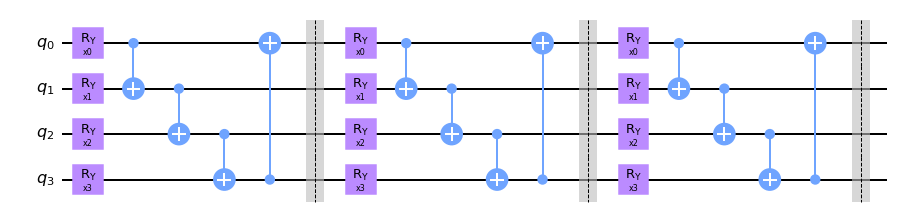

In [16]:
layer = 3
np.random.seed(seed)
nb_w = 4
weights = np.random.random(nb_w)
w_params = [Parameter(f'x{str(i)}') for i in range(nb_w)]

ansatz = ansatz_circ(feature_dim, layer, w_params)
ansatz.draw('mpl')

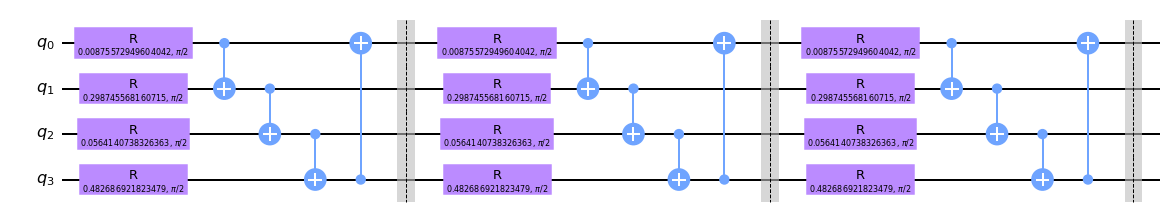

In [17]:
ansatz.assign_parameters({k:v for (k,v) in zip(ansatz.parameters, weights)}).decompose().draw('mpl', scale=1)

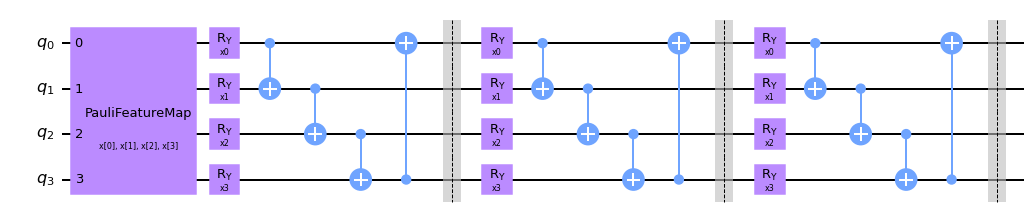

In [18]:
var_circuit = fmap.compose(ansatz)
var_circuit.draw('mpl')

In [19]:
def parity(x, num_classes):
    return f"{x:b}".count("1") % num_classes

def one_qubit_binary(x):
    return x % 2

In [20]:
qasm_sim = Aer.get_backend('aer_simulator')
qinst = QuantumInstance(qasm_sim, 2048, seed_simulator=seed)

In [21]:
num_classes = 2
qnn = CircuitQNN(circuit=var_circuit,
                 input_params=fmap.parameters,  # if your embedding strategy is not a parametrized circuit 
                                                   # (e.g. amplitude encoding) you will have to do some extra work!
                 weight_params=ansatz.parameters,  # if you train your embedding as well, the trainable
                                                      # parameters of the embedding must be added
                 interpret=one_qubit_binary,
                 output_shape=num_classes,
                 gradient=None,
                 quantum_instance=qinst)

In [22]:
output = qnn.forward(x_train[0], weights)
print(output.shape)
output

(1, 2)


array([[0.50927734, 0.49072266]])

In [23]:
_, update = qnn.backward(x_train[0], weights)
update

array([[[ 0.15771484, -0.00366211,  0.21850586, -0.03466797],
        [-0.15771484,  0.00366211, -0.21850586,  0.03466797]]])

In [24]:
def get_one_hot_encoding(y):
    unique_labels = np.unique(y, axis=0)
    y_one_hot = [(np.eye(len(unique_labels))[np.where(unique_labels == y_i)]).reshape(len(unique_labels)) for y_i in y]

    return np.array(y_one_hot)

y_train_1h = get_one_hot_encoding(y_train)
y_test_1h = get_one_hot_encoding(y_test)

In [25]:
def callback(nfev, params, fval, stepsize, accepted=None):
    """
    Can be used for SPSA and GradientDescent optimizers
    nfev: the number of function evals
    params: the current parameters
    fval: the current function value
    stepsize: size of the update step
    accepted: whether the step was accepted (not used for )
    """
    global loss_recorder

    loss_recorder.append(fval)
    print(f'{nfev} - {fval}')

In [26]:
max_itr = 50
spsa_opt = SPSA(maxiter=max_itr, callback=callback)
loss_recorder = []
np.random.seed(seed)
initial_point = np.random.random((len(ansatz.parameters),))
vqc = NeuralNetworkClassifier(neural_network=qnn,
                              loss=CrossEntropyLoss(),
                              one_hot=True,
                              optimizer=spsa_opt,
                              initial_point=initial_point)


vqc = vqc.fit(x_train, y_train_1h)

3 - 301.31174791794774
6 - 300.2217196453471
9 - 300.2480321317378
12 - 299.80678953718586
15 - 299.2751253061943
18 - 298.1438039537681
21 - 297.11361789383426
24 - 297.98326258574275
27 - 297.530944815703
30 - 296.49697317814173
33 - 296.916368781454
36 - 296.7601466394156
39 - 296.3117441998892
42 - 296.2739781924693
45 - 296.12297675817626
48 - 295.9989388606565
51 - 295.95656188493695
54 - 295.42364547414365
57 - 295.4945349216732
60 - 295.88066079508985
63 - 295.70726342512484
66 - 295.7793494324317
69 - 295.8059904857263
72 - 295.7842620517616
75 - 295.8814757510427
78 - 295.5729101981393
81 - 295.32458555283904
84 - 295.6259857790552
87 - 295.7870234947743
90 - 295.5416534989639
93 - 295.8023554675772
96 - 295.80088043725675
99 - 295.7087388860264
102 - 295.6116179979762
105 - 295.8923684576563
108 - 295.74301869437284
111 - 295.74794223008496
114 - 295.812281863704
117 - 295.8731499355962
120 - 295.62203888207466
123 - 295.6586631566388
126 - 295.80720847255344
129 - 295.67112

In [27]:
score_train_1 = vqc.score(x_train, y_train_1h)
score_test_1 = vqc.score(x_test, y_test_1h)
print(f'Score on the train set {score_train_1}')
print(f'Score on the test set {score_test_1}')

Score on the train set 0.5466666666666666
Score on the test set 0.5


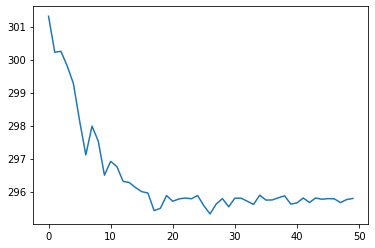

In [28]:
plt.plot(loss_recorder)

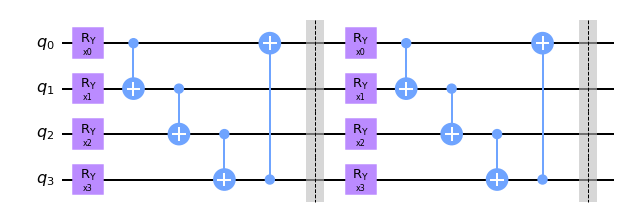

In [29]:
layer = 2
np.random.seed(seed)
weights = np.random.random(nb_w)
w_params = [Parameter(f'x{str(i)}') for i in range(nb_w)]

ansatz = ansatz_circ(feature_dim, layer, w_params)
ansatz.draw('mpl')

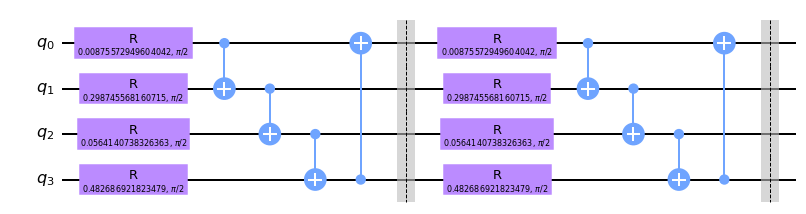

In [30]:
ansatz.assign_parameters({k:v for (k,v) in zip(ansatz.parameters, weights)}).decompose().draw('mpl', scale=1)

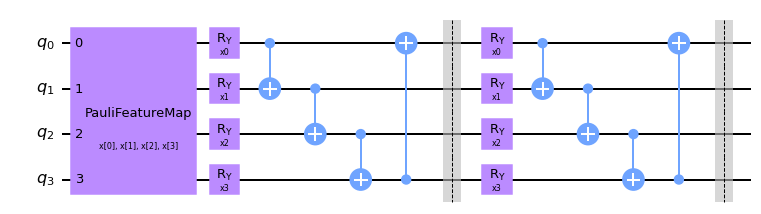

In [31]:
var_circuit = fmap.compose(ansatz)
var_circuit.draw('mpl')

In [32]:
qnn = CircuitQNN(circuit=var_circuit,
                 input_params=fmap.parameters,  # if your embedding strategy is not a parametrized circuit 
                                                   # (e.g. amplitude encoding) you will have to do some extra work!
                 weight_params=ansatz.parameters,  # if you train your embedding as well, the trainable
                                                      # parameters of the embedding must be added
                 interpret=one_qubit_binary,
                 output_shape=num_classes,
                 gradient=None,
                 quantum_instance=qinst)

In [33]:
output = qnn.forward(x_train[0], weights)
print(output.shape)
output

(1, 2)


array([[0.53466797, 0.46533203]])

In [34]:
_, update = qnn.backward(x_train[0], weights)
update

array([[[ 0.04321289,  0.10302734,  0.00878906,  0.04296875],
        [-0.04321289, -0.10302734, -0.00878906, -0.04296875]]])

In [35]:
max_itr = 50
spsa_opt = SPSA(maxiter=max_itr, callback=callback)
loss_recorder = []
np.random.seed(seed)
initial_point = np.random.random((len(ansatz.parameters),))
vqc = NeuralNetworkClassifier(neural_network=qnn,
                              loss=CrossEntropyLoss(),
                              one_hot=True,
                              optimizer=spsa_opt,
                              initial_point=initial_point)


vqc = vqc.fit(x_train, y_train_1h)

3 - 304.6484681675731
6 - 320.6837735099623
9 - 318.0587892505921
12 - 318.08762338681237
15 - 313.6053613571237
18 - 308.7216698743273
21 - 307.08745717342356
24 - 306.4912176450383
27 - 304.19144625061364
30 - 301.3088026857898
33 - 301.1190119166635
36 - 301.01411822056184
39 - 300.8969495802116
42 - 300.05842019698935
45 - 300.90408025666034
48 - 300.3144590564406
51 - 300.5520731343746
54 - 300.7097692430546
57 - 300.4199225384539
60 - 299.82483040711395
63 - 300.38883211766154
66 - 299.48261772891954
69 - 299.30460600505455
72 - 299.34424554648695
75 - 299.0805560214535
78 - 299.0520875751702
81 - 298.93098071675166
84 - 298.99186916642185
87 - 298.96062515660213
90 - 298.852599927917
93 - 298.77979827355796
96 - 298.641306893213
99 - 298.9309810454236
102 - 298.7996861874018
105 - 298.85380691561676
108 - 299.0713519185673
111 - 299.0668207373776
114 - 299.091241430742
117 - 299.14184610648124
120 - 299.0905506575387
123 - 299.11620021925944
126 - 299.14259462683185
129 - 299.11

In [36]:
score_train_2 = vqc.score(x_train, y_train_1h)
score_test_2 = vqc.score(x_test, y_test_1h)
print(f'Score on the train set {score_train_2}')
print(f'Score on the test set {score_test_2}')

Score on the train set 0.51
Score on the test set 0.525


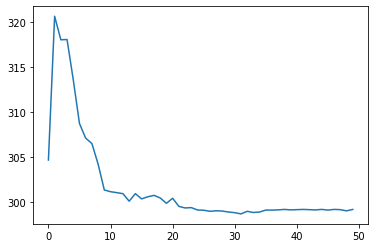

In [37]:
plt.plot(loss_recorder)

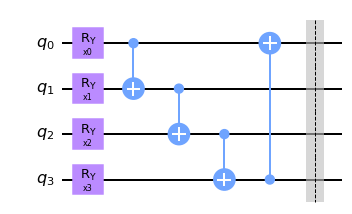

In [38]:
layer = 1
np.random.seed(seed)
weights = np.random.random(nb_w)
w_params = [Parameter(f'x{str(i)}') for i in range(nb_w)]

ansatz = ansatz_circ(feature_dim, layer, w_params)
ansatz.draw('mpl')

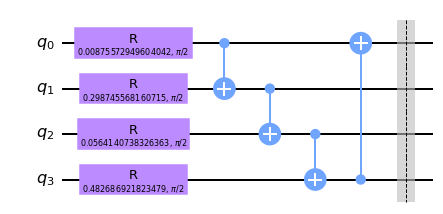

In [39]:
ansatz.assign_parameters({k:v for (k,v) in zip(ansatz.parameters, weights)}).decompose().draw('mpl', scale=1)

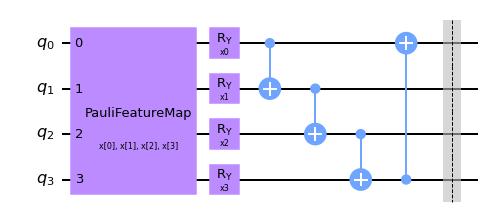

In [40]:
var_circuit = fmap.compose(ansatz)
var_circuit.draw('mpl')

In [41]:
qnn = CircuitQNN(circuit=var_circuit,
                 input_params=fmap.parameters,  # if your embedding strategy is not a parametrized circuit 
                                                   # (e.g. amplitude encoding) you will have to do some extra work!
                 weight_params=ansatz.parameters,  # if you train your embedding as well, the trainable
                                                      # parameters of the embedding must be added
                 interpret=one_qubit_binary,
                 output_shape=num_classes,
                 gradient=None,
                 quantum_instance=qinst)

In [42]:
output = qnn.forward(x_train[0], weights)
print(output.shape)
output

(1, 2)


array([[0.50341797, 0.49658203]])

In [43]:
_, update = qnn.backward(x_train[0], weights)
update

array([[[ 0.00219727,  0.02929687, -0.06469727,  0.03979492],
        [-0.00219727, -0.02929687,  0.06469727, -0.03979492]]])

In [44]:
max_itr = 50
spsa_opt = SPSA(maxiter=max_itr, callback=callback)
loss_recorder = []
np.random.seed(seed)
initial_point = np.random.random((len(ansatz.parameters),))
vqc = NeuralNetworkClassifier(neural_network=qnn,
                              loss=CrossEntropyLoss(),
                              one_hot=True,
                              optimizer=spsa_opt,
                              initial_point=initial_point)


vqc = vqc.fit(x_train, y_train_1h)

3 - 299.60064494639187
6 - 300.3511523537476
9 - 300.2320731620106
12 - 299.18481519054603
15 - 298.90115129366364
18 - 296.6317288798404
21 - 296.4874048860371
24 - 296.3254357556764
27 - 296.63874123683
30 - 296.6073211172802
33 - 296.5071830420735
36 - 296.4602086279538
39 - 296.3089336584708
42 - 296.3580057790758
45 - 296.2418890542135
48 - 296.16617369773894
51 - 295.82906686308047
54 - 295.8449017984634
57 - 295.8724463635761
60 - 295.7871357455356
63 - 295.76014571096744
66 - 295.5618682552623
69 - 295.76742999323716
72 - 295.77813158028613
75 - 295.89581939017353
78 - 295.9380865068799
81 - 295.94222045351006
84 - 295.8679177227939
87 - 295.96748361366133
90 - 295.91027543058107
93 - 295.8369702056461
96 - 295.8520687836211
99 - 295.856038118441
102 - 295.89504493317907
105 - 295.85507316508244
108 - 295.76085386426803
111 - 295.729047169435
114 - 295.57873433170903
117 - 295.60835641683195
120 - 295.86766504206264
123 - 295.6853187722504
126 - 295.70969427555866
129 - 295.724

In [45]:
score_train_3 = vqc.score(x_train, y_train_1h)
score_test_3 = vqc.score(x_test, y_test_1h)
print(f'Score on the train set {score_train_3}')
print(f'Score on the test set {score_test_3}')

Score on the train set 0.58
Score on the test set 0.49166666666666664


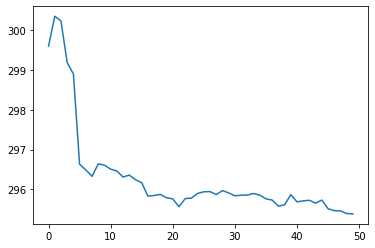

In [46]:
plt.plot(loss_recorder)